In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def lambdan(n,peak):
    beta=(20 + (8*np.sin(2*np.pi*(960+n)/1440)))*peak/29
    b=np.ceil(beta)
    return np.random.randint(low=b-10,high=b+10+1)



* E̶s̶c̶o̶l̶h̶e̶r̶ ̶a̶d̶i̶c̶i̶o̶n̶a̶r̶ ̶o̶u̶ ̶n̶a̶o̶ ̶u̶m̶ ̶u̶s̶u̶á̶r̶i̶o̶ ̶t̶a̶l̶v̶e̶z̶ ̶s̶e̶g̶u̶i̶n̶d̶o̶ ̶u̶m̶a̶ ̶s̶e̶n̶o̶i̶d̶e̶ ̶(̶d̶e̶ ̶q̶u̶a̶n̶t̶o̶ ̶e̶m̶ ̶q̶u̶a̶n̶t̶o̶ ̶t̶e̶m̶p̶o̶?̶ ̶t̶e̶s̶t̶a̶r̶ ̶a̶ ̶c̶a̶d̶a̶ ̶m̶i̶n̶u̶t̶o̶)̶
* A cada usuário alocar apenas um arquivo
* A cada minuto o sistema verá o estado (quanta capacidade é necessária)
* Aumentar os estados para incluir os de "bloqueio"

In [3]:
#def FTP(users):
#    mu = [32.542, 3, 4]
#    s = [1, 1, 2.54]
#    total_data = 2**np.random.normal(mu[0],s[0],users)
#    data_perfile = 2**np.random.normal(mu[1],s[1],users)
#    interval = 10**np.random.normal(mu[2],s[2],users)
#    return total_data,data_perfile,interval

In [16]:
states = []
maxu = 450
U = 25
maxre = 9
for ii in range(int(maxu/U)):
    for jj in range(maxre):
        states.append((ii+1) + 1j*(jj+1))

In [8]:
#def reward(ii,jj,u,maxu=450,U=50):
#        aa = jj - (450/50-1) #considerando "9 recursos"
#        if (ii + aa)*U>u:
#            rr = (450/50) - (ii+aa)
#        else:
#            rr = -1000
#        return rr
 
    
AJEITAR!!!!

In [30]:
def QT(actions,maxu=450,U=25,states=states,UpR):
    Q = np.zeros([len(states),actions])
    for ii in range(len(states)):
        for jj in range(actions):
            if np.real(states[ii])*U > (1-np.imag(states[ii])+jj)*UpR:
                Q[ii,jj] = #penalizar
            else:
                Q[ii,jj] = #bonificar
    return Q

SyntaxError: invalid syntax (<ipython-input-30-f60ae8f382a2>, line 6)

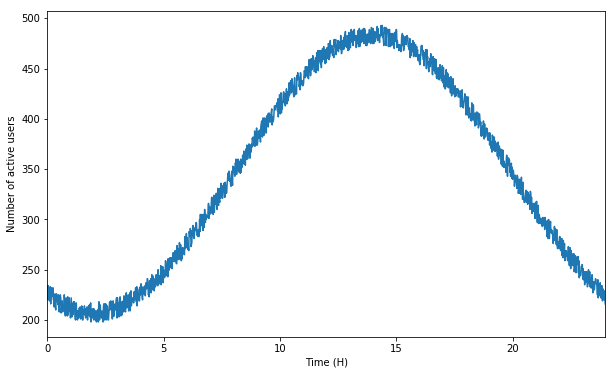

In [3]:
peak = 500
vtU=[]
for ii in range(0,60*24):
    vtU.append(lambdan(ii,peak))
seU=pd.Series(vtU)
seU.index=seU.index/(60)
seU.plot(figsize=(10,6))
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()

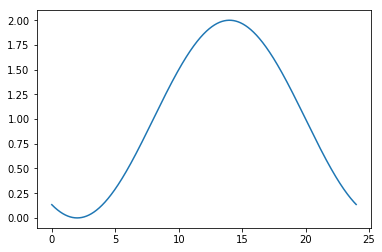

In [4]:
t = np.arange(24*60)
plt.plot(t/60,1+np.sin(2*np.pi*(960+t)/1440))
plt.show()

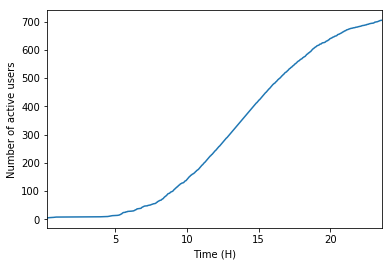

706

In [32]:
users = []
ii = []
user=5
for i in range(24*60):
    if np.random.uniform(low=0,high=2) <= 1+np.sin(2*np.pi*(960+i)/1440):
        users = np.append(users,user)
        ii.append(i)
        user = user+1
df = pd.Series(data = users,index=ii)
df.index = df.index/60
df.plot()
plt.xlabel('Time (H)')
plt.ylabel('Number of active users')
plt.show()


2.0